# scRNAseq analysis with francesco pipeline

9/24/22 succeed on pasca 22q11 scRNAseq data

Bin Xu

In [1]:
# definition reusable functions here
## set python env
def set_work_env(work_dir):
  import os as os
  from google.colab import drive
  drive.mount('/content/drive')
  # avoid whilespace in "My Drive"
  !mkdir /content/MyDrive
  !mount --bind /content/drive/My\ Drive /content/MyDrive
  os.chdir(work_dir)

  import sys
  sys.path.append('/content/MyDrive/py_libs/')

  # Load the common python libraries
  import matplotlib.pyplot as plt
  import numpy as np
  import pandas as pd
  import seaborn as sns

  sns.set_style('white')
  plt.rcParams['savefig.facecolor'] = 'w'
  print("*** work env is ready!")
  print("*** work dir is: " + os.getcwd())

## set R env
def set_R_env():
  import rpy2.rinterface_lib.callbacks
  import rpy2.robjects as ro
  import logging
  from rpy2.robjects import numpy2ri
  numpy2ri.activate()
  # Ignore R warning messages
  #Note: this can be commented out to get more verbose R output
  rpy2.rinterface_lib.callbacks.logger.setLevel(logging.WARNING)

  # Automatically convert rpy2 outputs to pandas dataframes
  from rpy2.robjects import pandas2ri
  import anndata2ri
  pandas2ri.activate()
  anndata2ri.activate()
  %load_ext rpy2.ipython

def fullpath_closure(data_dir):
  import os
  def fullpath(path):
    return os.path.join(data_dir, path)
  return fullpath


## #1 Define inputs and outputs settings before run

In [2]:
import pathlib
topDir = '/content/MyDrive/3_projects/22q11_organoids/22q_scRNAseq/Pasca_scRNAseq/'
prefix = 'pasca'
pathlib.Path(topDir)

inDir = pathlib.Path(topDir,"raw")
outDir = pathlib.Path(topDir,"outputs")
interDir = pathlib.Path(topDir,"inter")

In [4]:
set_work_env(topDir)

Mounted at /content/drive
*** work env is ready!
*** work dir is: /content/drive/MyDrive/Colab Notebooks/22q_scRNAseq/Pasca_scRNAseq


In [5]:
%cd {topDir}
outDir.mkdir(exist_ok=True)
interDir.mkdir(exist_ok=True)
%cd {outDir}

/content
/content/drive/MyDrive/Colab Notebooks/22q_scRNAseq/Pasca_scRNAseq/outputs


In [6]:
# Load the common libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import scanpy as sc

#### #0). [Run first time] Install the python env and package locally

In [ ]:
# To determine which version you're using:
# examples
# install locally
#!pip install scanpy --target='/content/drive/My Drive/py_libs/'
## this version of umap is needed by Ingest if needed
# install on system (need reinstall each runtime)
#!pip install 'umap-learn==0.3.10'

In [7]:
# run set_python_env function
set_python_env()
set_R_env()

NameError: ignored

In [ ]:
# run set_r_env function
# set_R_env()

In [5]:
%cd /content/MyDrive/3_projects/22q11_organoids/22q_scRNAseq/Pasca_scRNAseq/raw

/content/drive/MyDrive/Colab Notebooks/22q_scRNAseq/Pasca_scRNAseq/raw


## #2 Read matrix into AnnaData format

In [8]:
import scanpy as sc
import scipy as sp
import numpy as np

In [9]:
adata1 = sc.read_10x_mtx('/content/MyDrive/3_projects/22q11_organoids/22q_scRNAseq/Pasca_scRNAseq/raw/GSM4306931_Control_1',var_names='gene_symbols',cache=True, gex_only=True)
adata2 = sc.read_10x_mtx('/content/MyDrive/3_projects/22q11_organoids/22q_scRNAseq/Pasca_scRNAseq/raw/GSM4306932_Control_2',var_names='gene_symbols',cache=True, gex_only=True)
adata3 = sc.read_10x_mtx('/content/MyDrive/3_projects/22q11_organoids/22q_scRNAseq/Pasca_scRNAseq/raw/GSM4306933_Patient_1',var_names='gene_symbols',cache=True, gex_only=True)
adata4 = sc.read_10x_mtx('/content/MyDrive/3_projects/22q11_organoids/22q_scRNAseq/Pasca_scRNAseq/raw/GSM4306934_Patient_2',var_names='gene_symbols',cache=True, gex_only=True)


In [63]:
adata = adata1.concatenate(adata2,adata3,adata4)

/content/MyDrive/py_libs/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [65]:
adata.var

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression
...,...,...
AC233755.2,ENSG00000277856,Gene Expression
AC233755.1,ENSG00000275063,Gene Expression
AC240274.1,ENSG00000271254,Gene Expression
AC213203.1,ENSG00000277475,Gene Expression


In [66]:
# Conver X to csr format. this will dramatically reduce the data size. https://anndata.readthedocs.io/en/stable/anndata.AnnData.write_h5ad.html
from scipy.sparse import csr_matrix
adata.var_names_make_unique()
adata.X = csr_matrix(adata.X)
adata

AnnData object with n_obs × n_vars = 45300 × 33538
    obs: 'batch'
    var: 'gene_ids', 'feature_types'

## #5 Add annotation tables such as sampleID, batchID, condition

In [67]:
adata.obs['condition'] = adata.obs['batch'].map({
        '0': 'Control',
        '1': 'Control',
        '2': 'Parent',
        '3': 'Parent'
    })
adata.obs['sampleID'] = adata.obs['batch'].map({
        '0':'GSM4306931_Control_1',
        '1':'GSM4306932_Control_2',
        '2':'GSM4306933_Patient_1',
        '3':'GSM4306934_Patient_4'
    })

In [69]:
# save raw adata file
#adata.write(pathlib.Path(interDir,"pasca_aggr.h5ad"))

In [105]:
# read back 
adata = sc.read(pathlib.Path(interDir,"pasca_aggr.h5ad"))

In [106]:
adata.var_keys

<bound method AnnData.var_keys of AnnData object with n_obs × n_vars = 45300 × 33538
    obs: 'batch', 'condition', 'sampleID'
    var: 'gene_ids', 'feature_types'>

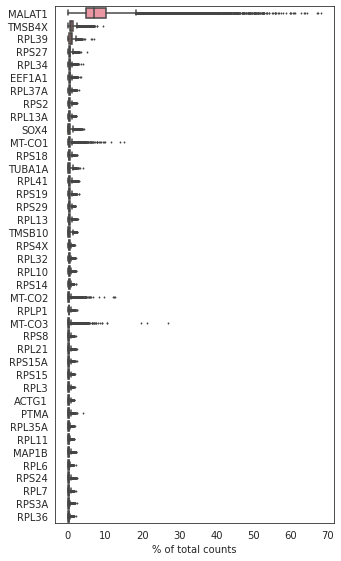

In [71]:
sc.pl.highest_expr_genes(adata, n_top=40, save='.raw_top40.pdf');

## #6. Computation of QC metrics

In [107]:
adata.var

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression
...,...,...
AC233755.2,ENSG00000277856,Gene Expression
AC233755.1,ENSG00000275063,Gene Expression
AC240274.1,ENSG00000271254,Gene Expression
AC213203.1,ENSG00000277475,Gene Expression


In [82]:
def adata_var_get(_adata, prefix_l=[], gene_l=[]):
    vars_l = set()
    for prefix in prefix_l:
        vars_l |= set(_adata.var.index[_adata.var.index.str.startswith(prefix)])
    vars_l |= set(_adata.var.index[_adata.var.index.isin(gene_l)])
    if vars_l:
        return _adata[:, list(vars_l)]
    else:
        return None

In [84]:
# get ribosome genes
ribo_p = adata_var_get(adata, prefix_l=['RPL', 'RPS', 'MRPL', 'MRPS'])
ribo_r = adata_var_get(adata, gene_l=['RN45S', 'RN4.5S'])
print(ribo_p)
print(ribo_r)

View of AnnData object with n_obs × n_vars = 45300 × 184
    obs: 'batch', 'condition', 'sampleID'
    var: 'gene_ids', 'feature_types'
None


In [103]:
#del adata.obs

In [110]:
adata.obs

,batch,condition,sampleID,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_counts_ribo_p,percent_ribo_p
AAACCTGAGCTCAACT-1-0,0,Control,GSM4306931_Control_1,3005,8070.0,143.0,1.771995,1452.0,17.992565
AAACCTGAGGAATGGA-1-0,0,Control,GSM4306931_Control_1,456,895.0,2.0,0.223464,54.0,6.033520
AAACCTGAGTAGATGT-1-0,0,Control,GSM4306931_Control_1,324,574.0,206.0,35.888500,56.0,9.756098
AAACCTGAGTCGCCGT-1-0,0,Control,GSM4306931_Control_1,1761,3499.0,49.0,1.400400,455.0,13.003715
AAACCTGAGTCTCCTC-1-0,0,Control,GSM4306931_Control_1,1533,3865.0,68.0,1.759379,1336.0,34.566624
...,...,...,...,...,...,...,...,...,...
TTTGTCATCGCAAACT-1-3,3,Parent,GSM4306934_Patient_4,1224,2337.0,36.0,1.540437,408.0,17.458280
TTTGTCATCGTAGATC-1-3,3,Parent,GSM4306934_Patient_4,1522,2843.0,33.0,1.160746,480.0,16.883574
TTTGTCATCGTAGGAG-1-3,3,Parent,GSM4306934_Patient_4,1446,3584.0,49.0,1.367188,1396.0,38.950893
TTTGTCATCTAACTTC-1-3,3,Parent,GSM4306934_Patient_4,1933,3466.0,101.0,2.914022,383.0,11.050202


In [109]:
# get mito genes
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# This is the way to generate good dataframe data. Avoid to use np operations!
adata.obs['n_counts_ribo_p'] = ribo_p.X.sum(axis=1).A1.tolist() 
adata.obs['percent_ribo_p'] = (100*ribo_p.X.sum(axis=1).transpose()/np.ravel(np.sum(adata.X, axis=1))).transpose().A1.tolist()


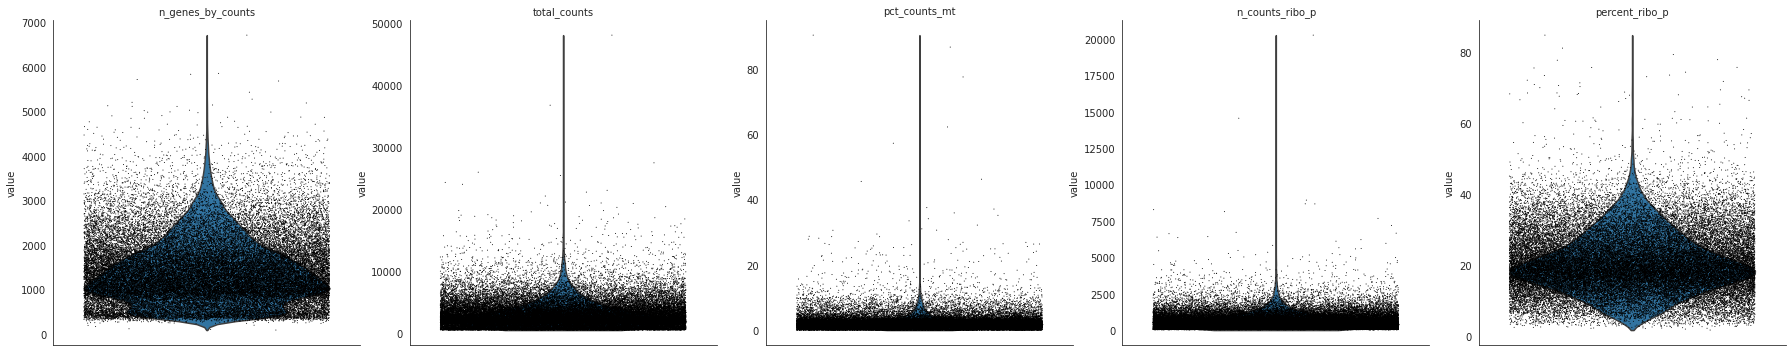

In [111]:
sc.pl.violin(
    adata,
    [
        'n_genes_by_counts',
        'total_counts',
        'pct_counts_mt',
        'n_counts_ribo_p',
        'percent_ribo_p',
    ],
    jitter=0.4,
    multi_panel=True,
    save='.qc.pdf'
)

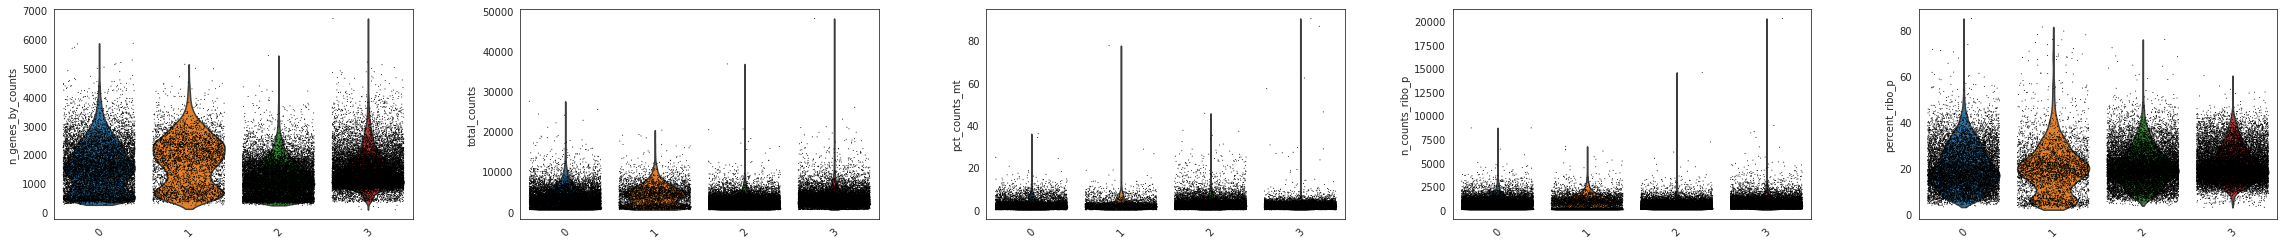

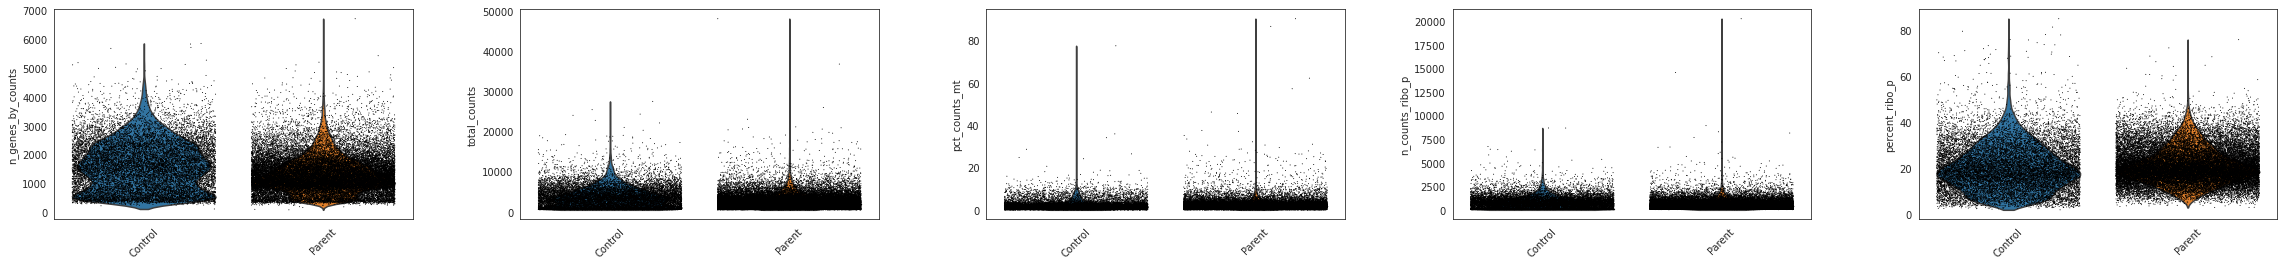

In [112]:
for gb in ['batch', 'condition']:
    sc.pl.violin(
        adata,
        [
        'n_genes_by_counts',
        'total_counts',
        'pct_counts_mt',
        'n_counts_ribo_p',
        'percent_ribo_p',
        ],
        jitter=0.4,
        save=f'.qc.{gb}.pdf',
        groupby=gb,
        rotation=45,
        cut=0,
    )

In [113]:
adata.write(pathlib.Path(interDir,"pasca_preqc.h5ad"))

## #7. Filtering of bad quality cells

In [ ]:
#adata = sc.read(f'interim_data/{prefix}.preqc.h5ad')

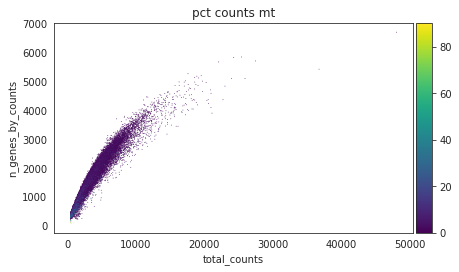

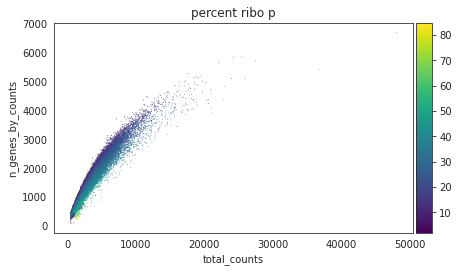

In [115]:
sc.pl.scatter(
    adata,
    color='pct_counts_mt',
    x='total_counts',
    y='n_genes_by_counts',
#    frameon=True,
    save='.qc.lib_detect_mito.pdf',
    color_map='viridis',
)
sc.pl.scatter(
    adata,
    color='percent_ribo_p',
    x='total_counts',
    y='n_genes_by_counts',
#    frameon=True,
    save='.qc.lib_detect_ribo_p.pdf',
    color_map='viridis',
)

In [116]:
# NOTE Mitochondrial percentage
# AGGR01: < .2
adata = adata[adata.obs['pct_counts_mt'] < 20, :]
# NOTE Number of detected genes
# AGGR01: >= 200, <= 8000
adata = adata[adata.obs['n_genes_by_counts'] >= 200, :]
adata = adata[adata.obs['n_genes_by_counts'] <= 8000, :]
# NOTE Number of counts
# AGGR01: <= 5e4
adata = adata[adata.obs['total_counts'] <= 5e4, :]

# # Complex filters for outliers
# NOTE
# adata = adata[
    # ~(
        # (adata.obs['n_genes'] < 500) 
        # & (adata.obs['n_counts'] > .5e4)
    # ), :
# ]
# adata = adata[
#     ~(
#         (adata.obs['n_genes']) / (adata.obs['n_counts']) < .08
#     ), :
# ]
# adata = adata[~((adata.obs['n_genes'] < 1500) & (adata.obs['n_counts'] > 5000)), :]
# adata = adata[~((adata.obs['n_genes'] < 2100) & (adata.obs['n_counts'] > 8000)), :]

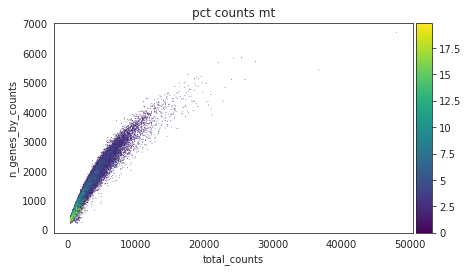

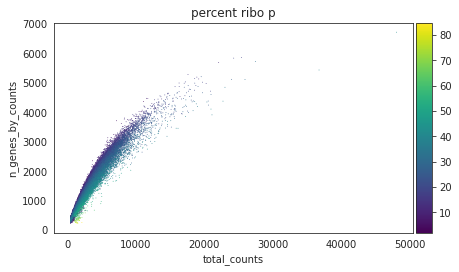

In [117]:
sc.pl.scatter(
    adata,
    color='pct_counts_mt',
    x='total_counts',
    y='n_genes_by_counts',
    frameon=True,
    save='.qc.lib_detect_mito.filter.pdf',
    color_map='viridis',
)
sc.pl.scatter(
    adata,
    color='percent_ribo_p',
    x='total_counts',
    y='n_genes_by_counts',
    frameon=True,
    save='.qc.lib_detect_ribo_p.filter.pdf',
    color_map='viridis',
)

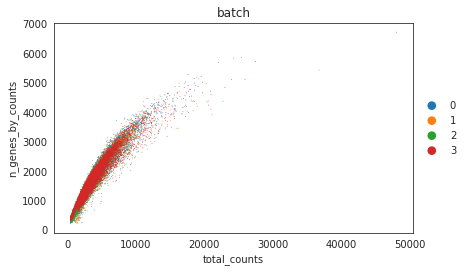

In [118]:
sc.pl.scatter(
    adata,
    color='batch',
    x='total_counts',
    y='n_genes_by_counts',
    frameon=True,
    save='.qc.lib_detect_batch.filter.pdf',
    color_map='viridis',
)

In [119]:
sc.pp.filter_genes(adata, min_cells=1)

/content/MyDrive/py_libs/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [120]:
# NOTE
# AGGR1: 33250 cells, 27573 genes
adata

AnnData object with n_obs × n_vars = 45214 × 25392
    obs: 'batch', 'condition', 'sampleID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts_ribo_p', 'percent_ribo_p'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'batch_colors', 'condition_colors'

## #8. Save to the interim folder

In [121]:
adata.write(pathlib.Path(interDir,"pasca_postqc.h5ad"))

## #9. Normalization with scran (BX version)
!!!  Francesco scran_normalization func is too mem intensity. I proceed individual steps here with carefully watching the memory usage
 del used variables and run gc.collect() frequently !!!



In [16]:
adata = sc.read(pathlib.Path(interDir,"pasca_postqc.h5ad"))

In [11]:
%%R
# add my drive libraries to the default libPaths 
.libPaths( c( "/content/drive/MyDrive/R2_libs/" , .libPaths() ) )
.libPaths();

[1] "/content/drive/MyDrive/R2_libs" "/usr/local/lib/R/site-library" 
[3] "/usr/lib/R/site-library"        "/usr/lib/R/library"            


In [11]:
import gc
gc.collect()

0

In [ ]:
# This is mem intensity
#adata = scran_normalize(adata)
#adata.layers['sf'] = adata.X

In [6]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("Rcpp", type = 'source')

In [ ]:
# downgrade for fixing invalid object for slot "i" in class "dgCMatrix error
# https://github.com/theislab/anndata2ri/issues/63
!pip install --force-reinstall 'rpy2==3.4.2'

In [12]:
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr
import gc
importr('scran')
numpy2ri.activate()


In [21]:
ro.r.assign('mat', adata.X.T)
qclust_params = 'mat'

In [22]:
ro.reval(f'cl <- quickCluster({qclust_params})')
csf_params = f'SingleCellExperiment::SingleCellExperiment(list(counts=mat)), clusters = cl'

In [23]:
import gc
del qclust_params
gc.collect()

853

In [24]:
ro.reval(f'mysce <-computeSumFactors({csf_params})')

dimnames(.) <- list(NULL,NULL)



<rpy2.rinterface.SexpS4 object at 0x7fb50ab10230> [RTYPES.S4SXP]

In [25]:
sf = np.asarray(ro.reval(f'sizeFactors(mysce)'))

In [26]:
#del csf_params
gc.collect()

66

In [ ]:
sf

array([0.64835968, 1.04531613, 0.75912557, ..., 1.0907617 , 1.08786441,
       0.07746672])

In [27]:
adata

AnnData object with n_obs × n_vars = 45214 × 25392
    obs: 'batch', 'condition', 'sampleID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts_ribo_p', 'percent_ribo_p'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'batch_colors', 'condition_colors'

In [28]:
adata.obs['sf'] = sf   
adata.layers['counts'] = adata.X.copy()
adata.X /= adata.obs['sf'].values[:, None]


In [29]:
from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.X)
numpy2ri.deactivate()
adata.layers['sf'] = adata.X

In [ ]:
del sf
gc.collect()

41

In [31]:
adata

AnnData object with n_obs × n_vars = 45214 × 25392
    obs: 'batch', 'condition', 'sampleID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts_ribo_p', 'percent_ribo_p', 'sf'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'batch_colors', 'condition_colors', 'log1p'
    layers: 'counts', 'sf'

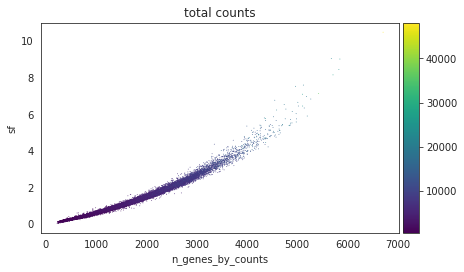

In [32]:
sc.pl.scatter(
    adata,
    color='total_counts',
    y='sf',
    x='n_genes_by_counts',
    color_map='viridis',
    save='.sf.pdf',
)

In [33]:
sc.pp.log1p(adata)
adata.write(pathlib.Path(interDir,"pasca_log1p.h5ad"))

## #10. Generate Liger inputs files

In [8]:
adata = sc.read(pathlib.Path(interDir,"pasca_log1p.h5ad"))

In [10]:
# file1 needed by liger in R
adata.X = adata.layers['counts']
adata.to_df().to_csv(pathlib.Path(interDir,'pasca_log1p.csv'))

In [11]:
# file2 needed by liger in R
sc.get.obs_df(adata, keys=adata.obs_keys()).to_csv(
    pathlib.Path(interDir,'pasca_log1p.metadata.csv')
)